In [1]:
import os
import random
import shutil
import hashlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, roc_auc_score, accuracy_score
from PIL import Image
from tensorflow.keras.losses import categorical_crossentropy
import pandas as pd


In [2]:
def preprocess_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen, val_test_datagen

def load_datasets(train_datagen, val_test_datagen, batch_size=64, target_size=(128, 128)):
    train_dir = "plantvillage dataset/splited/train" 
    val_dir = "plantvillage dataset/splited/validation"
    test_dir = "plantvillage dataset/splited/test"

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb'
    )

    return train_generator, validation_generator, test_generator

train_datagen, val_test_datagen = preprocess_data()
train_generator, validation_generator, test_generator = load_datasets(train_datagen, val_test_datagen)
class_names = list(train_generator.class_indices.keys())
class_count = len(class_names)
print("Number of classes:", class_count)
print(class_names)


Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.
Number of classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_bl

In [3]:
all_classes_name = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [4]:
def depthwise_separable_resnet_block(input_tensor, filters, kernel_size=3, stride=1,conv_shortcut=False):
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if conv_shortcut or stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

def squeeze_excitation_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=l2(0.01), use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=l2(0.01), use_bias=False)(se)

    x = layers.multiply([input_tensor, se])
    return x


def inception_with_SE_block(input_tensor, filters, l2_rate):

    conv1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv3x3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv5x5_1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)
    conv5x5_2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_1)
    conv5x5_3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_2)

    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_conv = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(pool)

    outputs = layers.concatenate([conv1x1, conv3x3, conv5x5_3, pool_conv], axis=-1)
    output_with_se = squeeze_excitation_block(outputs)
    return output_with_se

def spatial_attention_block(input_tensor):
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    
    avg_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(avg_pool)
    max_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(max_pool)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    output_tensor = layers.Multiply()([input_tensor, attention])
    return output_tensor

def Franklin_ensemble_model_1(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = depthwise_separable_resnet_block(x, filters=32)


    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x) 

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x) 
    x = spatial_attention_block(x) 
    
    x = inception_with_SE_block(x, 32, l2_rate) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    Franklin_ensemble_model_1 = models.Model(inputs=inputs, outputs=outputs)
    return Franklin_ensemble_model_1


input_1 InputLayer
conv2d Conv2D
batch_normalization BatchNormalization
re_lu ReLU
conv2d_1 Conv2D
batch_normalization_1 BatchNormalization
re_lu_1 ReLU
depthwise_conv2d DepthwiseConv2D
batch_normalization_2 BatchNormalization
conv2d_2 Conv2D
re_lu_2 ReLU
batch_normalization_3 BatchNormalization
add Add
re_lu_3 ReLU
conv2d_3 Conv2D
batch_normalization_4 BatchNormalization
re_lu_4 ReLU
conv2d_4 Conv2D
batch_normalization_5 BatchNormalization
re_lu_5 ReLU
depthwise_conv2d_1 DepthwiseConv2D
batch_normalization_6 BatchNormalization
conv2d_5 Conv2D
re_lu_6 ReLU
batch_normalization_7 BatchNormalization
add_1 Add
re_lu_7 ReLU
conv2d_6 Conv2D
max_pooling2d MaxPooling2D
global_average_pooling2d GlobalAveragePooling2D
global_max_pooling2d GlobalMaxPooling2D
reshape Reshape
reshape_1 Reshape
concatenate Concatenate
conv2d_7 Conv2D
multiply Multiply
conv2d_10 Conv2D
conv2d_11 Conv2D
max_pooling2d_1 MaxPooling2D
conv2d_8 Conv2D
conv2d_9 Conv2D
conv2d_12 Conv2D
conv2d_13 Conv2D
concatenate_1 Concate

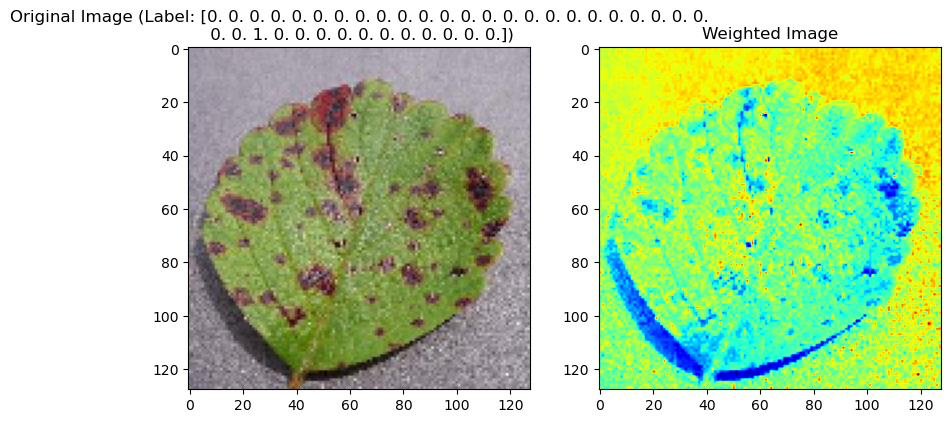

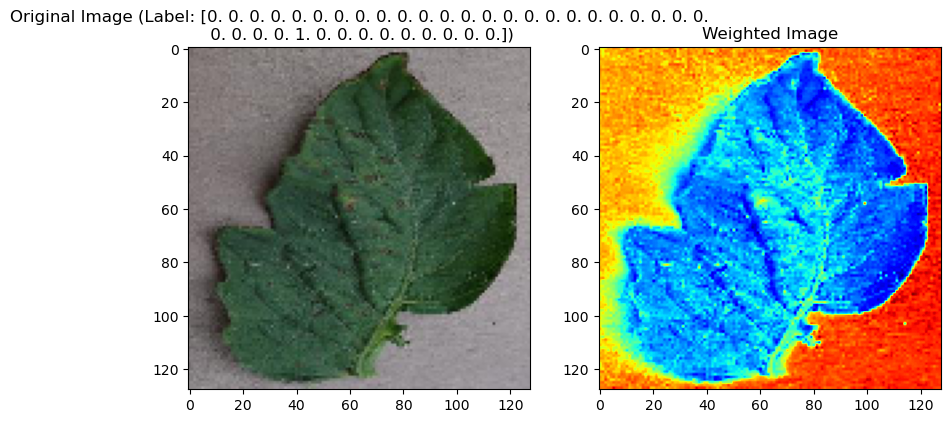

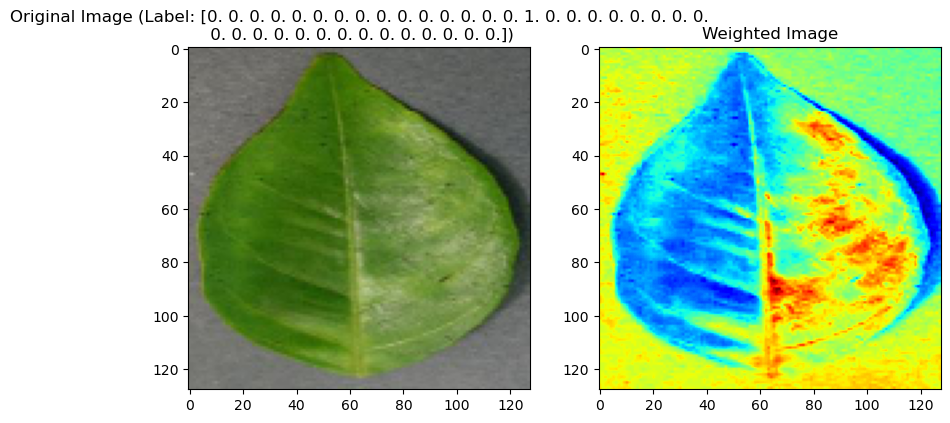

In [5]:
def attention_visualization_model(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = depthwise_separable_resnet_block(x, filters=32)
  

    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x)

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x) 
      
    x = inception_with_SE_block(x, 32, l2_rate) 
    x = spatial_attention_block(x) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    attention_visualization_model = models.Model(inputs=inputs, outputs=outputs)
    return attention_visualization_model

def generate_grad_cam(model, img_array, target_layer, output_layer):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(target_layer).output, model.get_layer(output_layer).output]
    )

    with tf.GradientTape() as tape:
        conv_output, model_output = grad_model(img_array)
        loss = tf.reduce_max(model_output, axis=1)
    grads = tape.gradient(loss, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap
input_shape = (128, 128, 3)
model = attention_visualization_model(input_shape, num_classes=2, l2_rate=0.0001)
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)


def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layers found in the model.")

last_conv_layer_name = find_last_conv_layer_name(model)
print(last_conv_layer_name)

output_layer_name = model.output.name.split("/")[0]

num_images = 3 

for i in range(num_images):
    batch = next(test_generator)

    img_array = batch[0]
    label = batch[1]

    heatmap1 = generate_grad_cam(model, img_array, last_conv_layer_name, output_layer_name)


    target_size = heatmap1.shape[0], heatmap1.shape[1]
    heatmap1_resized = tf.image.resize(heatmap1[..., np.newaxis], target_size)[..., 0]

    heatmap = heatmap1_resized 

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (input_shape[0], input_shape[1]))[..., 0]
    heatmap_expanded = tf.stack([heatmap_resized, heatmap_resized, heatmap_resized], axis=-1)


    weighted_img = heatmap_expanded * img_array[0]
    weighted_img /= np.max(weighted_img) if np.max(weighted_img) != 0 else 1


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title(f'Original Image (Label: {label[0]})')

    plt.subplot(1, 3, 2)
    plt.imshow(weighted_img[..., 0],cmap='jet')
    plt.title('Weighted Image')

    plt.show()


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

Franklin_ensemble_model_1 = Franklin_ensemble_model_1((128, 128, 3), num_classes=class_count, l2_rate=0.001)
Franklin_ensemble_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=categorical_crossentropy,
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)
Franklin_ensemble_model_1.summary()
print(Franklin_ensemble_model_1.optimizer) 
print(Franklin_ensemble_model_1.loss)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128, 128, 64  256        ['conv2d_22[0][0]']              
 rmalization)                   )                                                           

In [7]:
import os

# 定义主文件夹路径
main_folder = "modelPerformance"

# 创建主文件夹（如果不存在）
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

# 定义模型文件路径
model_filename = "Franklin_ensemble_model_1.h5"
model_path = os.path.join(main_folder, model_filename)

# 保存模型文件
Franklin_ensemble_model_1.save(model_path)

# 创建checkpoint文件夹路径
checkpoint_folder = os.path.join(main_folder, "checkpoints")

# 创建checkpoint文件夹（如果不存在）
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

# 定义checkpoint文件路径
checkpoint_filename = "model_checkpoint.h5"
checkpoint_path = os.path.join(checkpoint_folder, checkpoint_filename)

# 保存最佳模型 checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                    save_best_only=True, 
                                                    monitor='val_loss', 
                                                    mode='min')

# 创建日志文件夹路径
log_folder = os.path.join(main_folder, "logs")

# 创建日志文件夹（如果不存在）
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# 定义日志文件路径
log_filename = "training.log"
log_path = os.path.join(log_folder, log_filename)

# 创建 CSVLogger 回调来记录损失和准确率
csv_logger = tf.keras.callbacks.CSVLogger(log_path)

# 创建历史数据文件夹路径
history_folder = os.path.join(main_folder, "history_data")

# 创建历史数据文件夹（如果不存在）
if not os.path.exists(history_folder):
    os.makedirs(history_folder)

# 定义历史数据文件路径
history_filename = "training_history.csv"
history_path = os.path.join(history_folder, history_filename)

# 训练模型并保存历史数据
history1 = Franklin_ensemble_model_1.fit(train_generator, epochs=50, 
                                         validation_data=validation_generator,
                                         callbacks=[early_stopping, lr_reduction, model_checkpoint, csv_logger])

# 保存历史数据
history_df = pd.DataFrame(history1.history)
history_df.to_csv(history_path, index=False)


Epoch 1/50
679/679 [==============================] - 201s 295ms/step - loss: 2.0636 - accuracy: 0.5019 - precision: 0.8175 - recall: 0.3570 - val_loss: 1.3434 - val_accuracy: 0.6635 - val_precision: 0.7935 - val_recall: 0.5418 - lr: 0.0010
Epoch 2/50
679/679 [==============================] - 93s 137ms/step - loss: 0.9270 - accuracy: 0.7737 - precision: 0.8624 - recall: 0.6928 - val_loss: 1.7942 - val_accuracy: 0.6673 - val_precision: 0.7125 - val_recall: 0.6422 - lr: 0.0010
Epoch 3/50
679/679 [==============================] - 94s 139ms/step - loss: 0.6656 - accuracy: 0.8463 - precision: 0.8940 - recall: 0.8035 - val_loss: 1.1110 - val_accuracy: 0.7369 - val_precision: 0.7887 - val_recall: 0.6897 - lr: 0.0010
Epoch 4/50
679/679 [==============================] - 94s 138ms/step - loss: 0.5511 - accuracy: 0.8795 - precision: 0.9117 - recall: 0.8484 - val_loss: 0.9835 - val_accuracy: 0.7892 - val_precision: 0.8189 - val_recall: 0.7620 - lr: 0.0010
Epoch 5/50
679/679 [===================

In [8]:
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_checkpoint.h5", 
#                                                      save_best_only=True, 
#                                                      monitor='val_loss', 
#                                                      mode='min')



# history1 = Franklin_ensemble_model_1.fit(train_generator, epochs=50, 
#                                          validation_data=validation_generator,
#                                          callbacks=[early_stopping, lr_reduction, model_checkpoint])

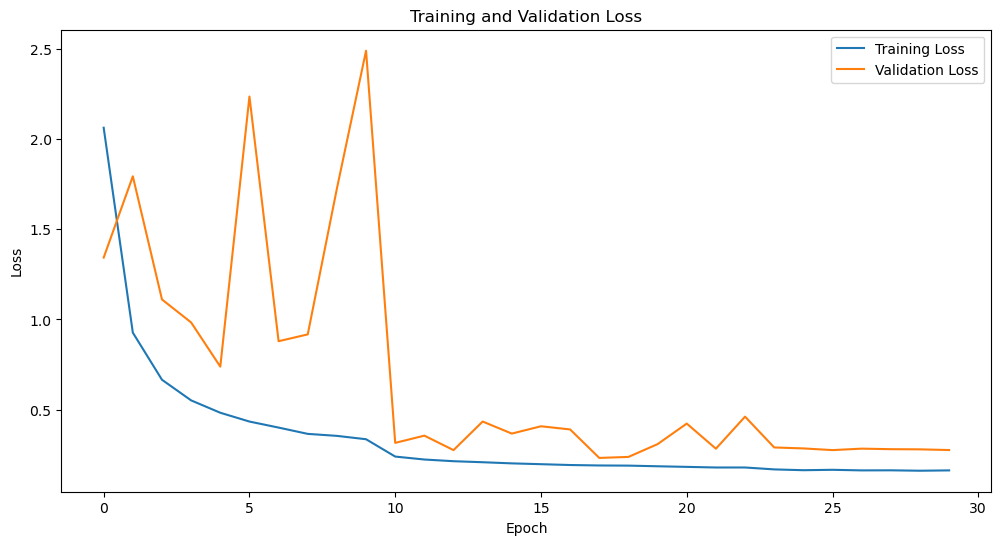

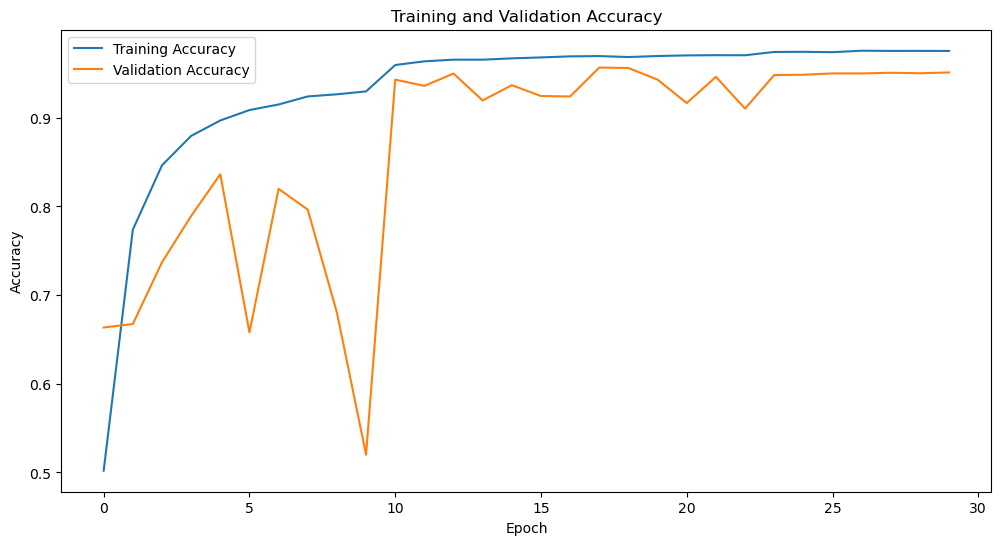

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取保存的训练历史数据
history_df = pd.read_csv(history_path)

# 可视化损失值
plt.figure(figsize=(12, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 可视化准确率
plt.figure(figsize=(12, 6))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# **Evaluate and Visualize Loss, Accuracy, ROC-AUC, Precision, PRC, F1-score, Recall, Sensitivity, Specificity, Confusion Matrix.**

In [10]:
valuation_result = Franklin_ensemble_model_1.evaluate(test_generator, steps=9)

9/9 [==============================] - 2s 182ms/step - loss: 0.2796 - accuracy: 0.9462 - precision: 0.9543 - recall: 0.9427


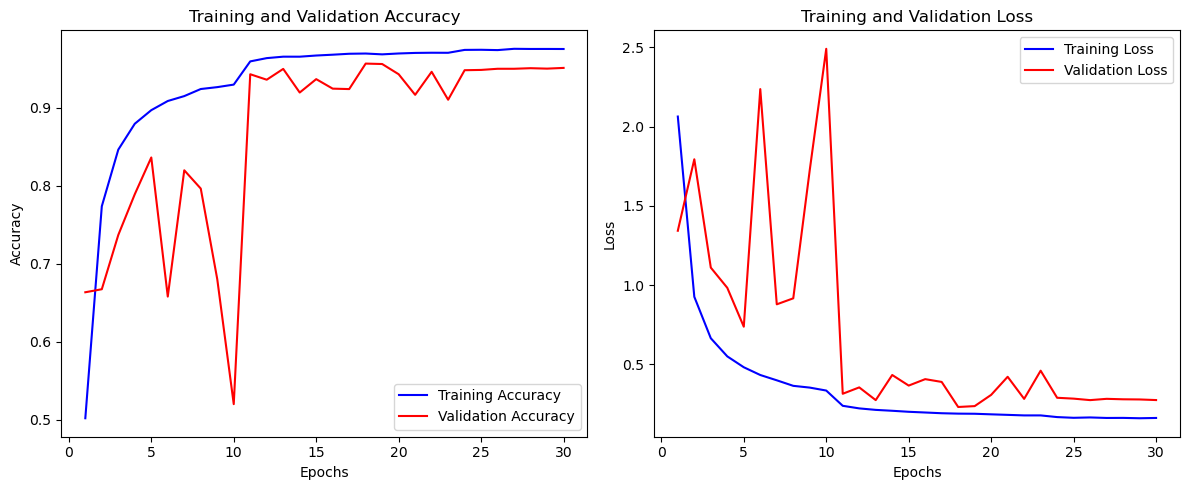

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss.

    Parameters:
    history: A Keras History object containing the training and validation loss and accuracy for each epoch.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 使用示例
plot_training_history(history1)


86/86 [==============================] - 15s 170ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        63
                                 Apple___Black_rot       0.04      0.05      0.04        63
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        28
                                   Apple___healthy       0.03      0.04      0.03       165
                               Blueberry___healthy       0.03      0.03      0.03       151
          Cherry_(including_sour)___Powdery_mildew       0.01      0.01      0.01       106
                 Cherry_(including_sour)___healthy       0.02      0.02      0.02        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.02      0.02      0.02        52
                       Corn_(maize)___Common_rust_       0.03      0.03      0.03       120
               Corn_(ma

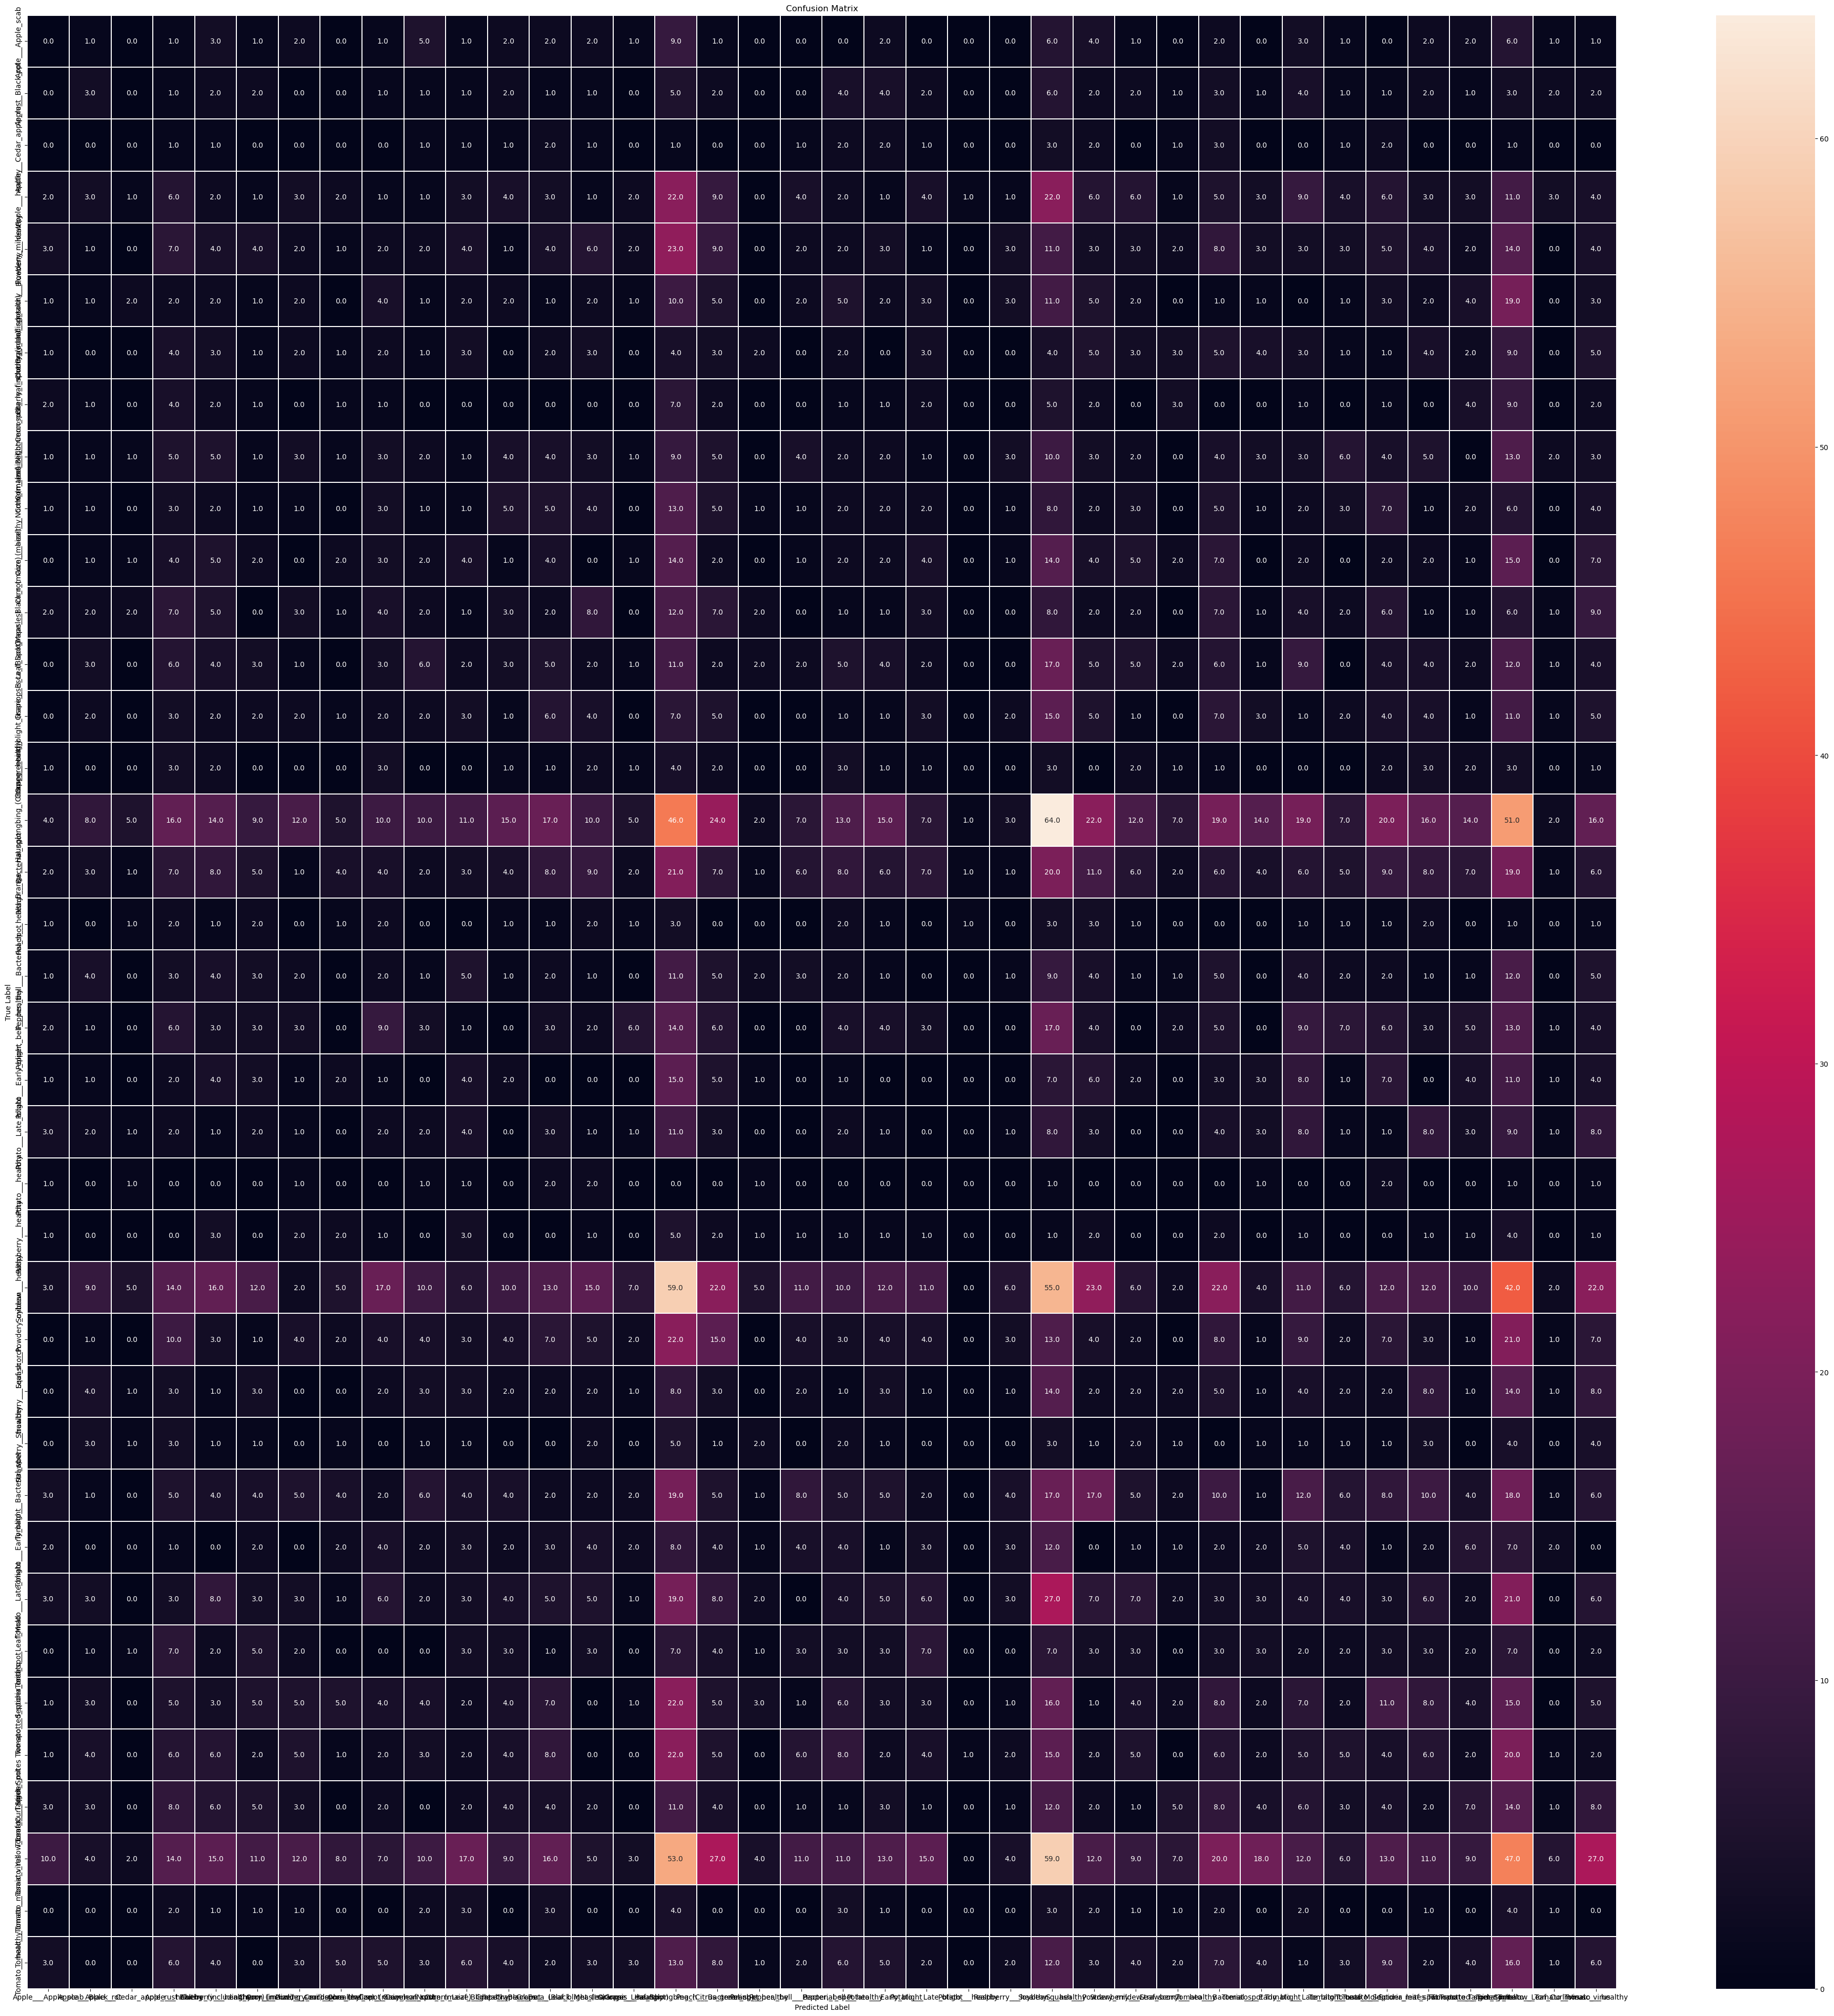

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = Franklin_ensemble_model_1.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
confusion = confusion_matrix(y_true, y_pred_labels)

print(classification_report(y_true, y_pred_labels, target_names=all_classes_name))
f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(confusion, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt='.1f',ax=ax,
            cmap="rocket")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(all_classes_name)
ax.yaxis.set_ticklabels(all_classes_name)
plt.title("Confusion Matrix")
plt.show()

In [13]:
from sklearn.metrics import f1_score
f1_micro = f1_score(y_true, y_pred_labels, average='micro')
f1_macro = f1_score(y_true, y_pred_labels, average='macro')
f1_weighted = f1_score(y_true, y_pred_labels, average='weighted')
print('F1-score (micro):', f1_micro)
print('F1-score (macro):', f1_macro)
print('F1-score (weighted):', f1_weighted)

F1-score (micro): 0.04689503572082799
F1-score (macro): 0.028902373783142858
F1-score (weighted): 0.04695208566176408


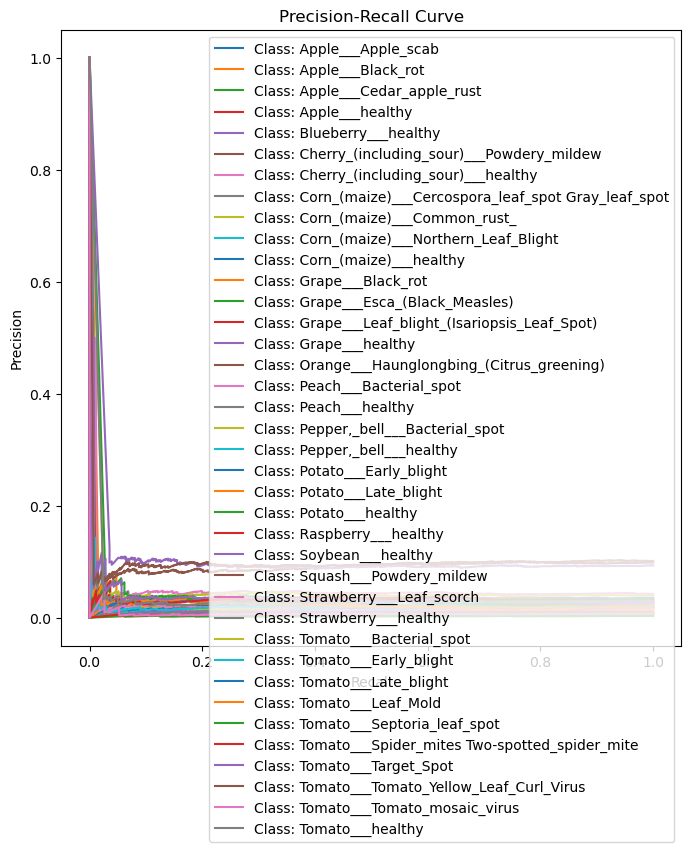

In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision = dict()
recall = dict()
thresholds = dict()
for i, class_label in enumerate(all_classes_name):
    precision[class_label], recall[class_label], thresholds[class_label] = precision_recall_curve(
        y_true == i, y_pred[:, i]
    )
plt.figure(figsize=(8, 8))
for class_label in all_classes_name:
    plt.plot(
        recall[class_label], precision[class_label], label=f'Class: {class_label}'
    )
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

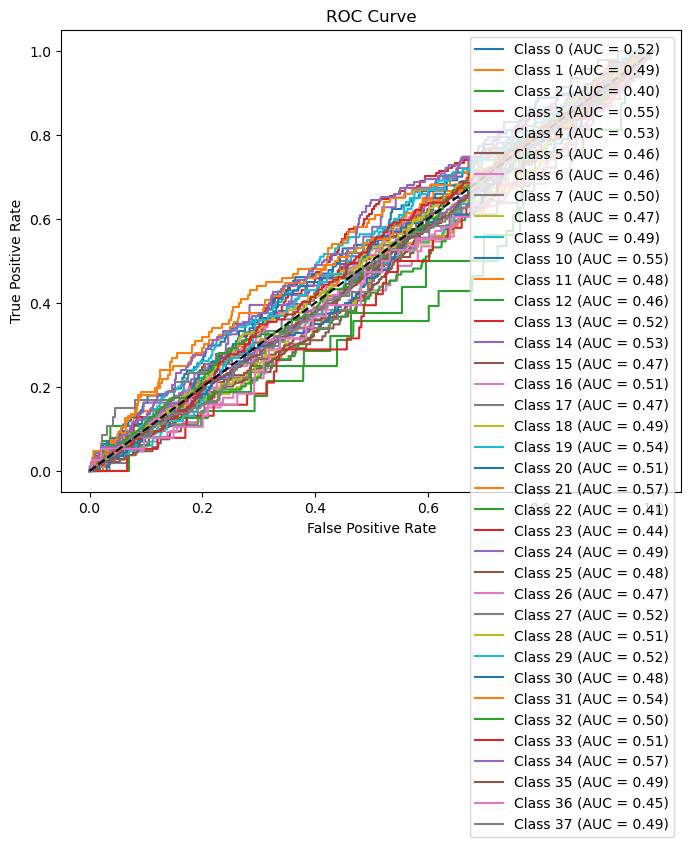

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_count):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(class_count):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:
cm = confusion_matrix(y_true, y_pred_labels)
sensitivity_per_class = recall_score(y_true, y_pred_labels, average=None)
specificity_per_class = []
for i in range(cm.shape[0]):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(true_negatives / (true_negatives + false_positives))

print("Sensitivity for each class:", sensitivity_per_class)
print("Specificity for each class:", specificity_per_class)

Sensitivity for each class: [0.         0.04761905 0.         0.03636364 0.02649007 0.00943396
 0.02325581 0.01923077 0.025      0.01010101 0.03418803 0.02542373
 0.03597122 0.03669725 0.02325581 0.08333333 0.03030303 0.
 0.02970297 0.02684564 0.         0.         0.         0.
 0.10805501 0.02173913 0.01785714 0.0212766  0.04672897 0.02
 0.02083333 0.02083333 0.06179775 0.03550296 0.04964539 0.08752328
 0.02631579 0.0375    ]
Specificity for each class: [0.9890659747961453, 0.9866567828020756, 0.9952126680169397, 0.9667548167737061, 0.9721175584024114, 0.9811320754716981, 0.9838079285315466, 0.989458109857592, 0.9782730848473496, 0.9822761194029851, 0.9788468738300262, 0.9805279910129189, 0.9725563909774436, 0.9792523364485981, 0.991506646971935, 0.8974933768086407, 0.958875286916603, 0.9935460077447907, 0.9843225083986562, 0.975517890772128, 0.977980966598246, 0.9796603844000746, 0.9990813889399228, 0.9907766094816455, 0.9024242424242425, 0.9658767772511848, 0.9796147372358331, 0.99